In [1]:
import numpy as np
import networkx as nx
import random
import time

In [2]:
import heapq
def create_graph(x, y, N, Tr, p):
    nodes = np.random.uniform(low=0, high=(x, y), size=(N, 2))

    # create adjacency matrix with all distances set to infinity
    adj_matrix = np.full((N, N), np.inf)

    # add edges between nodes based on transmission range Tr
    for i in range(N):
        for j in range(i+1, N):
            distance = np.linalg.norm(nodes[i] - nodes[j])
            if distance <= Tr:
                adj_matrix[i][j] = distance
                adj_matrix[j][i] = distance

    # randomly mark p nodes as DNs and remaining as SNs
    dn_nodes = np.random.choice(N, p, replace=False)
    node_types = np.where(np.isin(np.arange(N), dn_nodes), 'DN', 'SN')

    return nodes, adj_matrix, node_types

def prim_algorithm(graph):
    n = len(graph)
    visited = [False] * n
    parent = [None] * n
    key = [float('inf')] * n
    key[0] = 0
    queue = [(key[i], i) for i in range(n)]
    heapq.heapify(queue)

    while queue:
        u_key, u = heapq.heappop(queue)
        visited[u] = True

        for v in range(n):
            if not visited[v] and graph[u][v] < key[v]:
                key[v] = graph[u][v]
                parent[v] = u
                heapq.heappush(queue, (key[v], v))

    mst = [[float('inf')] * n for i in range(n)]
    for u in range(n):
        if parent[u] is not None:
            mst[u][parent[u]] = graph[u][parent[u]]
            mst[parent[u]][u] = graph[parent[u]][u]

    return mst

In [3]:
def is_graph_connected(graph):
    num_nodes = graph.shape[0]
    visited = np.zeros(num_nodes, dtype=bool)
    stack = [0]  # Start from node 0

    while stack:
        node = stack.pop()
        visited[node] = True
        neighbors = np.where(graph[node] > 0)[0]
        unvisited_neighbors = neighbors[~visited[neighbors]]
        stack.extend(unvisited_neighbors)
# 
    return np.all(visited)

In [4]:
def greedy1_algorithm(adj_matrix, prizes, budget):
    num_nodes = adj_matrix.shape[0]
    visited = np.zeros(num_nodes, dtype=bool)
    current_node = 0  # start from node 0
    visited[current_node] = True
    route = [current_node]
    total_cost = 0
    total_prizes = prizes[current_node]
    remaining_budget = budget

    while not np.all(visited):
        unvisited_mask = np.logical_not(visited)
        dist_to_unvisited = np.where(visited, np.inf, adj_matrix[current_node])
        dist_to_unvisited = np.where(unvisited_mask, dist_to_unvisited, -np.inf)
        
        next_node = np.argmax(prizes / dist_to_unvisited)
        next_distance = adj_matrix[current_node][next_node]
        
        if next_distance > remaining_budget:
            break
        
        visited[next_node] = True
        route.append(next_node)
        total_cost += next_distance
        total_prizes += prizes[next_node]
        remaining_budget -= next_distance
        current_node = next_node

    route.append(0)  # return to node 0
    total_cost += adj_matrix[current_node][0]
    
    return route, total_cost, total_prizes, remaining_budget

In [5]:
def greedy2_algorithm(distance_matrix, prizes, budget):
    num_nodes = distance_matrix.shape[0]
    visited = np.zeros(num_nodes, dtype=bool)
    current_node = 0  # start from node 0
    visited[current_node] = True
    route = [current_node]
    cost = 0
    total_prizes = prizes[current_node]
    remaining_budget = budget

    while not np.all(visited):
        dist_to_unvisited = np.where(visited, np.inf, distance_matrix[current_node])
        max_ratio = -np.inf
        next_node = -1
        for node in range(num_nodes):
            if not visited[node]:
                ratio = prizes[node] / dist_to_unvisited[node]
                if ratio > max_ratio:
                    max_ratio = ratio
                    next_node = node
        if dist_to_unvisited[next_node] > remaining_budget:
            break
        visited[next_node] = True
        route.append(next_node)
        cost += dist_to_unvisited[next_node]
        total_prizes += prizes[next_node]
        remaining_budget -= dist_to_unvisited[next_node]
        current_node = next_node

    route.append(0)  # return to node 0
    cost += distance_matrix[current_node][0]
    return route, cost, total_prizes, remaining_budget

In [6]:
import numpy as np

def MARL_algorithm(distance_matrix, prizes, budget, num_agents=100, max_iterations=10000):
    num_nodes = distance_matrix.shape[0]
    Q = np.zeros((num_nodes, num_nodes, num_agents))
    routes = [[] for _ in range(num_agents)]
    costs = np.zeros(num_agents)
    total_prizes = np.zeros(num_agents)
    remaining_budgets = np.ones(num_agents) * budget
    visited = np.zeros((num_nodes, num_agents), dtype=bool)
    current_node = np.zeros(num_agents, dtype=int)
    visited[current_node, :] = True
    t = 0

    while t < max_iterations and not np.all(visited):
        t += 1

        for i in range(num_agents):
            dist_to_unvisited = np.where(visited[:, i], np.inf, distance_matrix[current_node[i]])
            q_values = Q[:, :, i] + prizes - dist_to_unvisited
            valid_next_node = np.argmax(q_values)
            
            if dist_to_unvisited[valid_next_node] > remaining_budgets[i]:
                continue

            Q[current_node[i], valid_next_node, i] += (prizes[valid_next_node] - dist_to_unvisited[valid_next_node] +
                                                       0.9 * np.max(Q[valid_next_node, :, i]) -
                                                       Q[current_node[i], valid_next_node, i])

            visited[valid_next_node, i] = True
            routes[i].append(int(valid_next_node))
            costs[i] += dist_to_unvisited[valid_next_node]
            total_prizes[i] += prizes[valid_next_node]
            remaining_budgets[i] -= dist_to_unvisited[valid_next_node]
            current_node[i] = valid_next_node

    for i in range(num_agents):
        routes[i].append(0)
        costs[i] += distance_matrix[current_node[i], 0]

    max_index = np.argmax(total_prizes)
    return routes[max_index], costs[max_index], total_prizes[max_index], remaining_budgets[max_index]

In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def main():
    # Prompt user for input
    x = input("Enter the width x of the sensor network (default: 2000): ")
    y = input("Enter the length y of the sensor network (default: 2000): ")
    N = int(input("Enter the number of sensor nodes (default: 100): "))
    Tr = int(input("Enter the transmission range in meters (default: 400): "))
    p = int(input("Enter the number of DNs (default: 50): "))
    q = int(input("Enter the maximum number of data packets each DN has (default: 1000): "))
#     #Test Data
#     x = 2000
#     y = 2000
#     N = 100
#     Tr = 400
#     p = 50
#     q = 1000
    
    x = float(x)
    y = float(y)
    
    nodes, adj_matrix, node_types = create_graph(x, y, N, Tr, p)
    
    prizes = []
    dn_indices = []
    dn_data_packets = []

    for _ in range(N):
        prizes.append(random.uniform(0, q))

    available_indices = list(range(N))
    for _ in range(p):
        index = random.choice(available_indices)
        dn_indices.append(index)
        available_indices.remove(index)

    for _ in range(p):
        dn_data_packets.append(random.randint(1, q + 1))
    
    if (is_graph_connected(adj_matrix)):
        print("The Graph is Connected")
        # find minimum spanning tree using Prim's algorithm
        mst = prim_algorithm(adj_matrix)

        # visualize graph
        fig, ax = plt.subplots()
        for i in range(len(nodes)):
            if node_types[i] == "DN":
                ax.scatter(nodes[i][0], nodes[i][1], c='lime', s=100, marker='s')
            else:
                ax.scatter(nodes[i][0], nodes[i][1], c='blue', s=50)
        for i in range(len(adj_matrix)):
            for j in range(len(adj_matrix)):
                if adj_matrix[i][j] != float('inf'):
                    ax.plot([nodes[i][0], nodes[j][0]], [nodes[i][1], nodes[j][1]], c='brown')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        print("\nMinimum Spanning Tree")
        plt.show()

        # visualize graph
        fig, ax = plt.subplots()
        for i in range(len(nodes)):
            if node_types[i] == "DN":
                ax.scatter(nodes[i][0], nodes[i][1], c='lime', s=100, marker='s')
            else:
                ax.scatter(nodes[i][0], nodes[i][1], c='blue', s=50)
        for i in range(len(mst)):
            for j in range(len(mst)):
                if mst[i][j] != float('inf'):
                    ax.plot([nodes[i][0], nodes[j][0]], [nodes[i][1], nodes[j][1]], c='brown')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.show()
        # Print the IDs of DNs and the number of data packets each has
        print("DNs and their data packets:")
        for i in range(p):
            print(f"DN {dn_indices[i]}: {dn_data_packets[i]} data packets")
            
        st = time.time()
        route, cost, total_prizes, remaining_budget = greedy1_algorithm(adj_matrix, prizes, Tr)
        et = time.time()
        rt = et - st
        # Print the results
        print('\nDetails for Greedy 1 Algorithm')
        print("Route: ", route)
        print("Cost: ", cost)
        print("Total Prizes: ", total_prizes)
        print("Remaining Budget: ", remaining_budget)
        print("Running time: {:.7f} seconds".format(rt))

        # Call the greedy2_algorithm function
        st = time.time()
        route, cost, total_prizes, remaining_budget = greedy2_algorithm(adj_matrix, prizes, Tr)
        et = time.time()
        rt = et - st
        # Print the results
        print('\nDetails for Greedy 2 Algorithm')
        print("Route: ", route)
        print("Cost: ", cost)
        print("Total Prizes: ", total_prizes)
        print("Remaining Budget: ", remaining_budget)
        print("Running time: {:.7f} seconds".format(rt))

        # Call the MARL_algorithm function
        st = time.time()
        route, cost, total_prizes, remaining_budget = MARL_algorithm(adj_matrix, prizes, Tr)
        et = time.time()
        rt = et - st
        # Print the results
        print('\nDetails for MARL Algorithm')
        print("Route: ", route)
        print("Cost: ", cost)
        print("Total Prizes: ", total_prizes)
        print("Remaining Budget: ", remaining_budget)
        print("Running time: {:.7f} seconds".format(rt))
    else:
        print("Graph is not connected")

Enter the width x of the sensor network (default: 2000): 2000
Enter the length y of the sensor network (default: 2000): 2000
Enter the number of sensor nodes (default: 100): 100
Enter the transmission range in meters (default: 400): 400
Enter the number of DNs (default: 50): 50
Enter the maximum number of data packets each DN has (default: 1000): 1000
The Graph is Connected

Minimum Spanning Tree


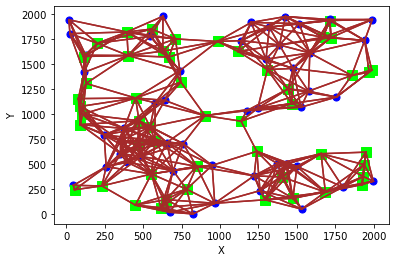

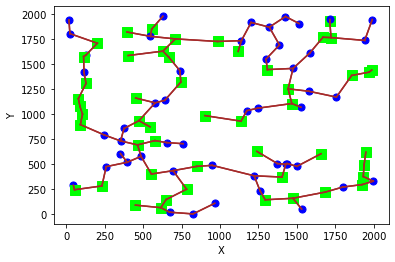

DNs and their data packets:
DN 80: 634 data packets
DN 1: 614 data packets
DN 36: 331 data packets
DN 83: 874 data packets
DN 16: 543 data packets
DN 15: 440 data packets
DN 46: 599 data packets
DN 43: 945 data packets
DN 74: 61 data packets
DN 2: 827 data packets
DN 30: 684 data packets
DN 6: 293 data packets
DN 86: 221 data packets
DN 56: 38 data packets
DN 0: 657 data packets
DN 26: 497 data packets
DN 33: 895 data packets
DN 40: 600 data packets
DN 69: 131 data packets
DN 78: 236 data packets
DN 10: 149 data packets
DN 5: 209 data packets
DN 51: 964 data packets
DN 53: 21 data packets
DN 82: 289 data packets
DN 48: 582 data packets
DN 84: 531 data packets
DN 58: 280 data packets
DN 75: 176 data packets
DN 35: 52 data packets
DN 21: 999 data packets
DN 65: 452 data packets
DN 28: 77 data packets
DN 24: 525 data packets
DN 13: 334 data packets
DN 8: 266 data packets
DN 97: 600 data packets
DN 55: 512 data packets
DN 57: 221 data packets
DN 62: 574 data packets
DN 91: 650 data packets

In [10]:
main()